<a href="https://colab.research.google.com/github/selvimaharanip/bi-analyst-portfolio/blob/main/bootcamp-projects/ab-testing/ab_testing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Testing Experimentation

A/B testing is an experimental method used in business to compare two or more variants of a product, feature, or strategy by exposing them to different user groups and measuring their impact on key performance metrics. Its primary function is to enable data-driven decision-making by isolating the effect of specific changes—such as design, messaging, pricing, or user experience—on user behavior and business outcomes.

By applying statistical analysis to determine whether observed differences are significant, A/B testing helps organizations reduce uncertainty, minimize risk, optimize performance, and continuously improve products or processes based on empirical evidence rather than assumptions or intuition.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

df = pd.read_csv("/content/drive/MyDrive/Bootcamp/Sample data/homework_ab_app_subscription_small.csv")

In [ ]:
print("DataFrame created from uploaded CSV:")
print(df.head())

DataFrame created from uploaded CSV:
   period cohort_date variant    user_id country platform traffic_source  \
0  during  2025-07-05       B  APP201334      ID  android        organic   
1  during  2025-07-04       A  APP201596      ID  android        organic   
2  during  2025-07-06       A  APP200545      TH  android        organic   
3  during  2025-07-07       B  APP203155      MY  android        organic   
4  during  2025-07-04       A  APP202354      ID  android           paid   

  device_model  age  sessions_7d  time_to_first_action_min  trial_start  \
0      low_end   54            4                       6.1            0   
1      low_end   24            2                       6.5            0   
2    mid_range   41            4                       7.3            0   
3    mid_range   40            1                       2.3            0   
4    mid_range   49            6                       2.4            1   

   paid_subscriber  revenue_30d  
0                0   

In [ ]:
df.head(10)

,period,cohort_date,variant,user_id,country,platform,traffic_source,device_model,age,sessions_7d,time_to_first_action_min,trial_start,paid_subscriber,revenue_30d
0,during,2025-07-05,B,APP201334,ID,android,organic,low_end,54,4,6.1,0,0,444.616527
1,during,2025-07-04,A,APP201596,ID,android,organic,low_end,24,2,6.5,0,0,424.835708
2,during,2025-07-06,A,APP200545,TH,android,organic,mid_range,41,4,7.3,0,0,393.086785
3,during,2025-07-07,B,APP203155,MY,android,organic,mid_range,40,1,2.3,0,0,502.190971
4,during,2025-07-04,A,APP202354,ID,android,paid,mid_range,49,6,2.4,1,0,432.384427
5,during,2025-07-09,A,APP203378,IN,android,organic,mid_range,20,1,4.7,0,0,476.151493
6,during,2025-07-09,B,APP203084,ID,android,organic,mid_range,52,6,2.7,0,0,518.731703
7,during,2025-07-15,B,APP207518,ID,android,paid,mid_range,32,4,3.7,0,0,433.653476
8,during,2025-07-05,B,APP207944,TH,ios,paid,mid_range,49,7,8.7,0,0,477.023732
9,during,2025-07-04,B,APP206023,ID,android,organic,low_end,17,7,4.4,1,0,317.936633


In [ ]:
# Filter during & split variants

dataset_during = df[df['period']=='during'].copy()
A = dataset_during[dataset_during['variant']=='A']
B = dataset_during[dataset_during['variant']=='B']

In [ ]:
# Variants A (control variables)

A.head()

,period,cohort_date,variant,user_id,country,platform,traffic_source,device_model,age,sessions_7d,time_to_first_action_min,trial_start,paid_subscriber,revenue_30d
1,during,2025-07-04,A,APP201596,ID,android,organic,low_end,24,2,6.5,0,0,424.835708
2,during,2025-07-06,A,APP200545,TH,android,organic,mid_range,41,4,7.3,0,0,393.086785
4,during,2025-07-04,A,APP202354,ID,android,paid,mid_range,49,6,2.4,1,0,432.384427
5,during,2025-07-09,A,APP203378,IN,android,organic,mid_range,20,1,4.7,0,0,476.151493
10,during,2025-07-09,A,APP200167,ID,android,organic,mid_range,31,5,1.7,0,0,388.292331


In [ ]:
# Variants B (experimental variables)

B.head()

,period,cohort_date,variant,user_id,country,platform,traffic_source,device_model,age,sessions_7d,time_to_first_action_min,trial_start,paid_subscriber,revenue_30d
0,during,2025-07-05,B,APP201334,ID,android,organic,low_end,54,4,6.1,0,0,444.616527
3,during,2025-07-07,B,APP203155,MY,android,organic,mid_range,40,1,2.3,0,0,502.190971
6,during,2025-07-09,B,APP203084,ID,android,organic,mid_range,52,6,2.7,0,0,518.731703
7,during,2025-07-15,B,APP207518,ID,android,paid,mid_range,32,4,3.7,0,0,433.653476
8,during,2025-07-05,B,APP207944,TH,ios,paid,mid_range,49,7,8.7,0,0,477.023732


# Normality Check (Shapiro–Wilk Test)

In [ ]:
# Shapiro test for both Variant A and B towards revenue_30d

shapiro_a = shapiro(A['revenue_30d'])
shapiro_b = shapiro(B['revenue_30d'])

print(f"Shapiro-Wilk test for Variant A: Statistics={shapiro_a.statistic:.4f}, p-value={shapiro_a.pvalue:.4f}")
print(f"Shapiro-Wilk test for Variant B: Statistics={shapiro_b.statistic:.4f}, p-value={shapiro_b.pvalue:.4f}")

Shapiro-Wilk test for Variant A: Statistics=0.9919, p-value=0.1668
Shapiro-Wilk test for Variant B: Statistics=0.9967, p-value=0.8805


Shapiro–Wilk Criterion:

* If the p-value > 0.05 → the data are normally distributed
* If the p-value ≤ 0.05 → the data are not normally distributed

In this case, Variant A has a p-value of 0.1668 and Variant B has a p-value of 0.8805, both of which exceed the 0.05 threshold.

Therefore, the revenue_30d distributions for both variants can be considered normal, and there is no significant evidence that the data deviate from a normal distribution.

This condition allows the use of parametric tests such as the t-test to compare revenue between Variant A and Variant B. However, before proceeding, it is necessary to ensure that there are no outliers that could distort the distribution.

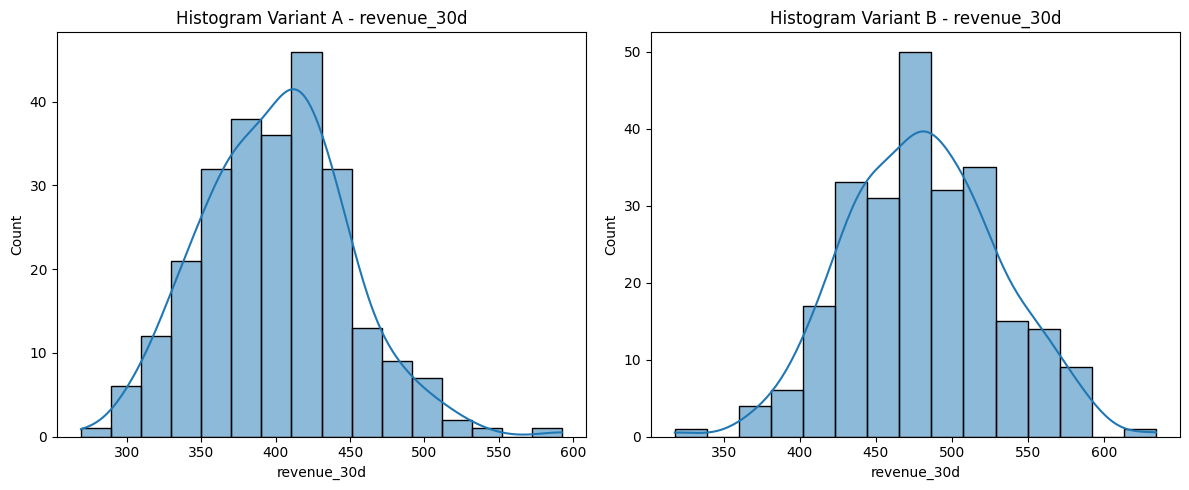

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

plt.figure(figsize=(12, 5))

# Variant A
plt.subplot(1, 2, 1)
sns.histplot(A['revenue_30d'], kde=True)
plt.title("Histogram Variant A - revenue_30d")

# Variant B
plt.subplot(1, 2, 2)
sns.histplot(B['revenue_30d'], kde=True)
plt.title("Histogram Variant B - revenue_30d")

plt.tight_layout()
plt.show()

Based on the histogram results, no anomalies or extreme values were identified that could potentially shift the distribution. Consequently, the next step is to conduct a homogeneity of variance test (Levene’s Test) to verify whether both groups have similar variances.

# Homogenity of Variance (Levene's Test)

Levene’s Test Criterion:

* If p-value > 0.05 → variances are considered homogeneous
* If p-value ≤ 0.05 → variances are considered not homogeneous

In [ ]:
from scipy.stats import levene

stat, p_value = levene(A['revenue_30d'], B['revenue_30d'])

print("Levene Test (Homogeneity of Variances)")
print("Statistic:", stat)
print("p-value:", p_value)

# Interpretation
alpha = 0.05
if p_value > alpha:
    print("Variances are considered homogeneous")
else:
    print("Variances are not homogeneous")

Levene Test (Homogeneity of Variances)
Statistic: 0.10047044439630178
p-value: 0.7513973263028337
Variances are considered homogeneous


The Levene’s Test result shows a p-value of 0.7514, which is well above the 0.05 threshold. Therefore, it can be concluded that the variances between the two groups are homogeneous. As a result, the analysis can proceed using a t-test under the assumption of equal variances (equal_var=True).

# Statistical Testing (Independent t-test)

Hypotheses to be tested:

**H0 (Null Hypothesis)**: Variant B does not increase revenue_30d per user compared to Variant A.

**H1 (Alternative Hypothesis)**: Variant B increases revenue_30d per user compared to Variant A.

In [ ]:
from scipy.stats import ttest_ind

# Since variances are homogeneous → use equal_var=True
stats, p_value = ttest_ind(A['revenue_30d'], B['revenue_30d'], equal_var=True)

print("Independent t-test (Equal Variances)")
print("Statistic:", stats)
print("p-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Statistically significant result (reject H0). This means Variant B increases revenue_30d per user compared to Variant A.")
else:
    print("Not statistically significant (fail to reject H0). This means Variant B does not increase revenue_30d per user compared to Variant A.")

Independent t-test (Equal Variances)
Statistic: -18.342420905397265
p-value: 6.435448411416861e-58
Statistically significant result (reject H0). This means Variant B increases revenue_30d per user compared to Variant A.


# Metric Calculation

Calculating the difference in values between the control variant (A) and the experimental variant (B).

In [ ]:
mean_A = A['revenue_30d'].mean()
mean_B = B['revenue_30d'].mean()

diff = mean_B - mean_A

print("Average of Variant A: {:.2f} and Variant B: {:.2f}".format(mean_A, mean_B))
print("The difference between the two variants is {:.2f}".format(diff))

Average of Variant A: 400.29 and Variant B: 480.67
The difference between the two variants is 80.38


In [ ]:
mean_A = A['revenue_30d'].mean()
mean_B = B['revenue_30d'].mean()

uplift_abs = (mean_B - mean_A)
uplift_perc = round((mean_B - mean_A)/mean_A*100,2)

print("Uplift Absolut; ", uplift_abs)
print("Uplift Percent; {}%".format(uplift_perc))

Uplift Absolut;  80.37932246318115
Uplift Percent; 20.08%


# Conclusion

Based on the results of the A/B Testing analysis on the revenue_30d metric, the following conclusions are obtained:

Variant A has an average revenue of **400.29**, while Variant B has an average of **480.67**, resulting in an **increase of 80.38** for Variant B.

After conducting a series of statistical tests, including the normality test (Shapiro–Wilk), variance homogeneity test (Levene’s Test), and significance test (independent t-test), the results indicate that the data are normally distributed, the variances between groups are homogeneous, and the p-value from the t-test is < 0.05. These findings show that **H0 is rejected**, leading to the conclusion that **Variant B increases revenue_30d per user compared to Variant A**.

Therefore, Variant B is statistically proven to deliver higher revenue performance than Variant A, with an average difference of 80.38. The uplift calculation shows an **absolute uplift of 80.38** and a **percentage uplift of 20.08%**, indicating a substantial improvement in revenue.

Overall, these results suggest that the changes implemented in the onboarding flow and paywall copy in Variant B have a **positive** impact on user behavior during the trial and conversion process, thereby contributing to increased revenue within the first 30 days of app usage.